In [120]:
# TED Videos Analytics Report - Jupyter Notebook Script

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import isodate
import matplotlib.pyplot as plt
import psycopg2
import os
import seaborn as sns
from dotenv import load_dotenv

sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

load_dotenv()

True

In [121]:
POSTGRES_HOST = os.getenv('POSTGRES_HOST')
POSTGRES_PORT = os.getenv('POSTGRES_PORT')
POSTGRES_DB = os.getenv('POSTGRES_DB')
POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

try:
    conn = psycopg2.connect(
        host=POSTGRES_HOST,
        port=POSTGRES_PORT,
        dbname=POSTGRES_DB,
        user=POSTGRES_USER,
        password=POSTGRES_PASSWORD
    )

    query = "SELECT * FROM fact_video_metrics;"
    df_metrics = pd.read_sql_query(query, conn)

    query_info = "SELECT * FROM dim_video_info;"
    df_info = pd.read_sql_query(query_info, conn)

    if df_metrics.empty or df_info.empty:
        print("Dataset could not be loaded. Please check the table names.")
    else:
        print("Datasets loaded successfully.")
        print(df_metrics.head())
        print(df_info.head())

except Exception as e:
    print(f"Error connecting to the database: {e}")

finally:
    if conn:
        conn.close()

df = pd.merge(df_metrics, df_info, on='video_id')

C:\Users\siwan\AppData\Local\Temp\ipykernel_6648\2863075674.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_metrics = pd.read_sql_query(query, conn)
C:\Users\siwan\AppData\Local\Temp\ipykernel_6648\2863075674.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_info = pd.read_sql_query(query_info, conn)


Datasets loaded successfully.
      video_id        published_at  view_count  like_count  comment_count  \
0  pOdIn86ZM1E 2024-05-13 19:36:01       14170         251              0   
1  Z6bxX3mcfJg 2024-10-16 11:00:42       27785         930             99   
2  0Mi0miIN6tA 2024-06-03 20:00:00       27074         648             64   
3  54AYOd5S7uo 2024-04-18 14:00:07       46595        1091             81   
4  iMBJrvEwv8s 2022-07-21 16:08:30     2513812       49112            788   

   duration  
0  PT12M24S  
1  PT13M48S  
2   PT15M6S  
3   PT9M40S  
4  PT12M34S  
      video_id                                              title  \
0  KKNCiRWd_j0     What Is an AI Anyway? | Mustafa Suleyman | TED   
1  DAkZpaYa4ZM  How to get the sleep you really need @TED #ted...   
2  bM1LXa68oxc  Leadership Lessons From the Prime Minister of ...   
3  CeUoS2T2hhc  What’s the Future of Food? A Chef + a Cardiolo...   
4  7Fiaew7nDmE  A Brain Implant That Turns Your Thoughts Into ...   

        

In [122]:
# Step 3: Data Overview
print("\nBasic Dataset Information")
print(df.info())

print("\nFirst Few Rows of the Dataset")
print(df.head())


Basic Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       142 non-null    object        
 1   published_at   142 non-null    datetime64[ns]
 2   view_count     142 non-null    int64         
 3   like_count     142 non-null    int64         
 4   comment_count  142 non-null    int64         
 5   duration       142 non-null    object        
 6   title          142 non-null    object        
 7   description    142 non-null    object        
 8   category       142 non-null    object        
 9   tags           142 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 11.2+ KB
None

First Few Rows of the Dataset
      video_id        published_at  view_count  like_count  comment_count  \
0  pOdIn86ZM1E 2024-05-13 19:36:01       14170         251              0

In [123]:
# Step 4: Handle Missing Data
def convert_duration(duration_str):
    try:
        return isodate.parse_duration(duration_str).total_seconds()
    except:
        return None

df['duration_seconds'] = df['duration'].apply(convert_duration)

non_numeric_columns = ['video_id']

df_numeric = df.drop(columns=non_numeric_columns).apply(pd.to_numeric, errors='coerce')

df = pd.concat([df_numeric, df[non_numeric_columns]], axis=1)

df.fillna(0, inplace=True)

In [124]:
# Step 5: Basic Descriptive Statistics
print("\nBasic Descriptive Statistics")
print(df.describe())

# Add skewness and kurtosis to understand data distribution
df_skew_kurt = df.select_dtypes(include=np.number).agg(['skew', 'kurtosis']).T
print("\nSkewness and Kurtosis of Numerical Columns")
print(df_skew_kurt)


Basic Descriptive Statistics
       published_at    view_count    like_count  comment_count  duration  \
count  1.420000e+02  1.420000e+02     142.00000     142.000000     142.0   
mean   1.713122e+18  1.931449e+05    5542.00000     467.021127       0.0   
std    2.368615e+16  5.835776e+05   26489.16721    2056.105978       0.0   
min    1.638374e+18  1.028000e+04       0.00000       0.000000       0.0   
25%    1.714753e+18  3.203925e+04     676.75000      39.000000       0.0   
50%    1.718674e+18  4.686050e+04    1126.50000      79.000000       0.0   
75%    1.726564e+18  1.122535e+05    2473.75000     208.500000       0.0   
max    1.729681e+18  6.003904e+06  308218.00000   23096.000000       0.0   

       title  description    category   tags  duration_seconds  
count  142.0        142.0  142.000000  142.0        142.000000  
mean     0.0          0.0   26.739437    0.0        850.183099  
std      0.0          0.0    2.712408    0.0        661.466795  
min      0.0          0.0

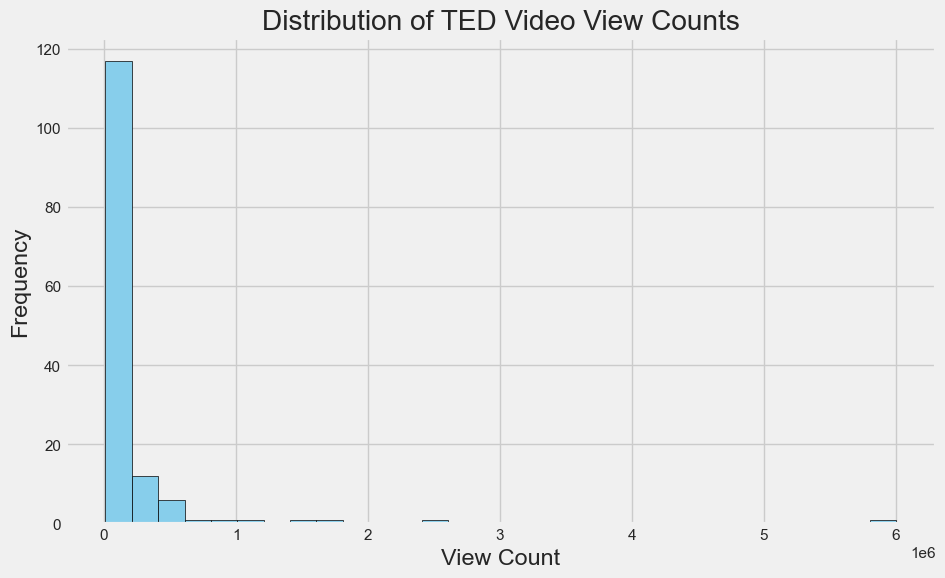

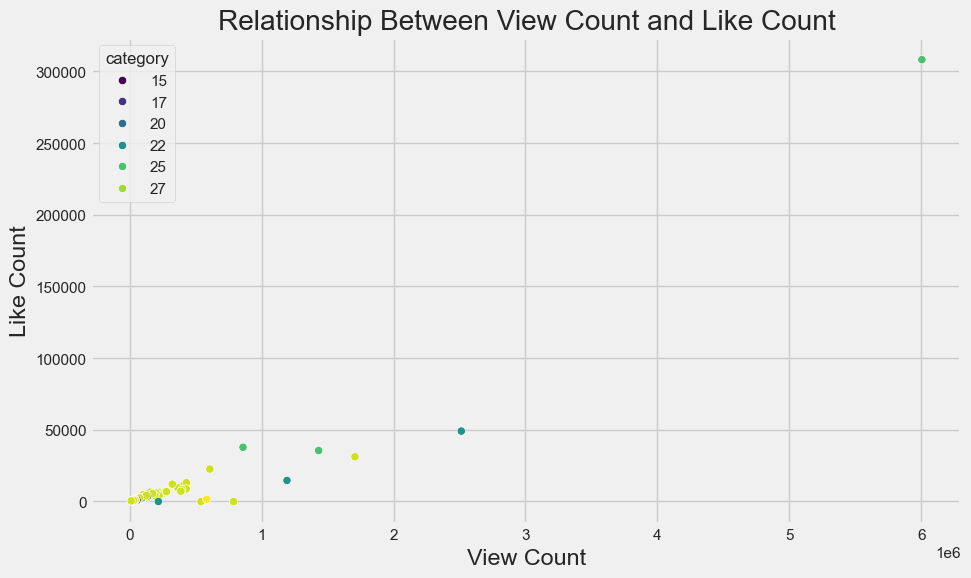

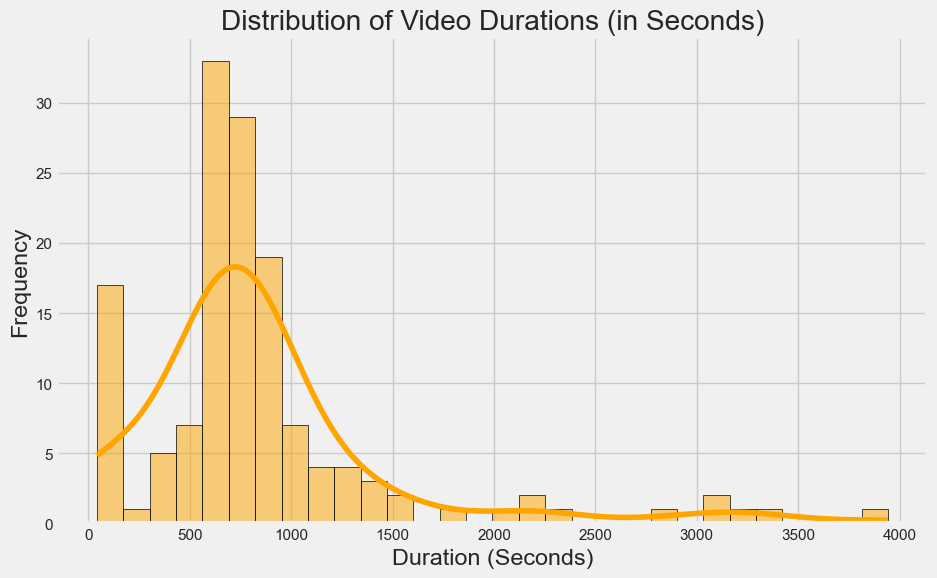

In [125]:
# Step 7: Visualizations
plt.figure(figsize=(10, 6))
plt.hist(df['view_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of TED Video View Counts')
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='view_count', y='like_count', hue='category', palette='viridis')
plt.title('Relationship Between View Count and Like Count')
plt.xlabel('View Count')
plt.ylabel('Like Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['duration_seconds'], bins=30, kde=True, color='orange', edgecolor='black')
plt.title('Distribution of Video Durations (in Seconds)')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Frequency')
plt.show()


Correlation Matrix


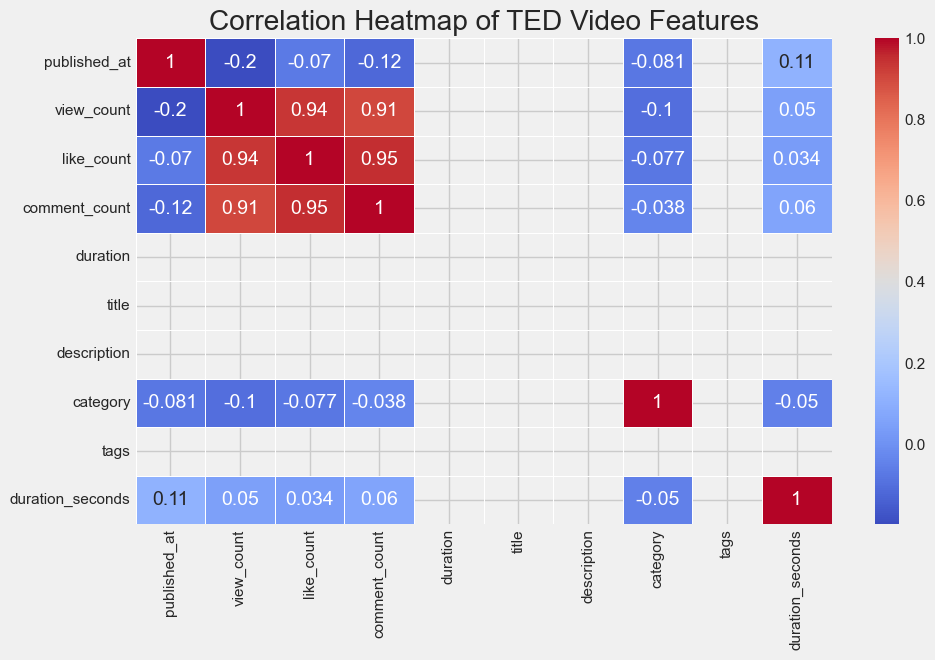

In [126]:
# Step 8: Correlation Analysis
print("\nCorrelation Matrix")
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Heatmap to visualize correlation between numeric variables
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of TED Video Features')
plt.show()

C:\Users\siwan\AppData\Local\Temp\ipykernel_6648\3509907838.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='popularity_status', data=df, palette='viridis')


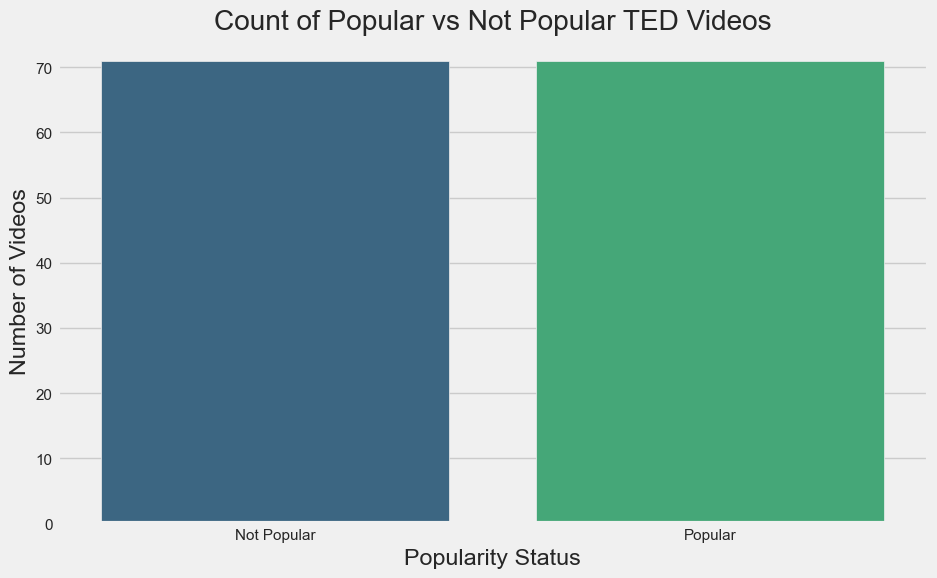

In [127]:
# Step 9: Analysis of Popularity
popularity_threshold = df['view_count'].median()
df['popularity_status'] = df['view_count'].apply(lambda x: 'Popular' if x > popularity_threshold else 'Not Popular')

# Visualize the count of popular vs not popular videos
plt.figure(figsize=(10, 6))
sns.countplot(x='popularity_status', data=df, palette='viridis')
plt.title('Count of Popular vs Not Popular TED Videos')
plt.xlabel('Popularity Status')
plt.ylabel('Number of Videos')
plt.show()


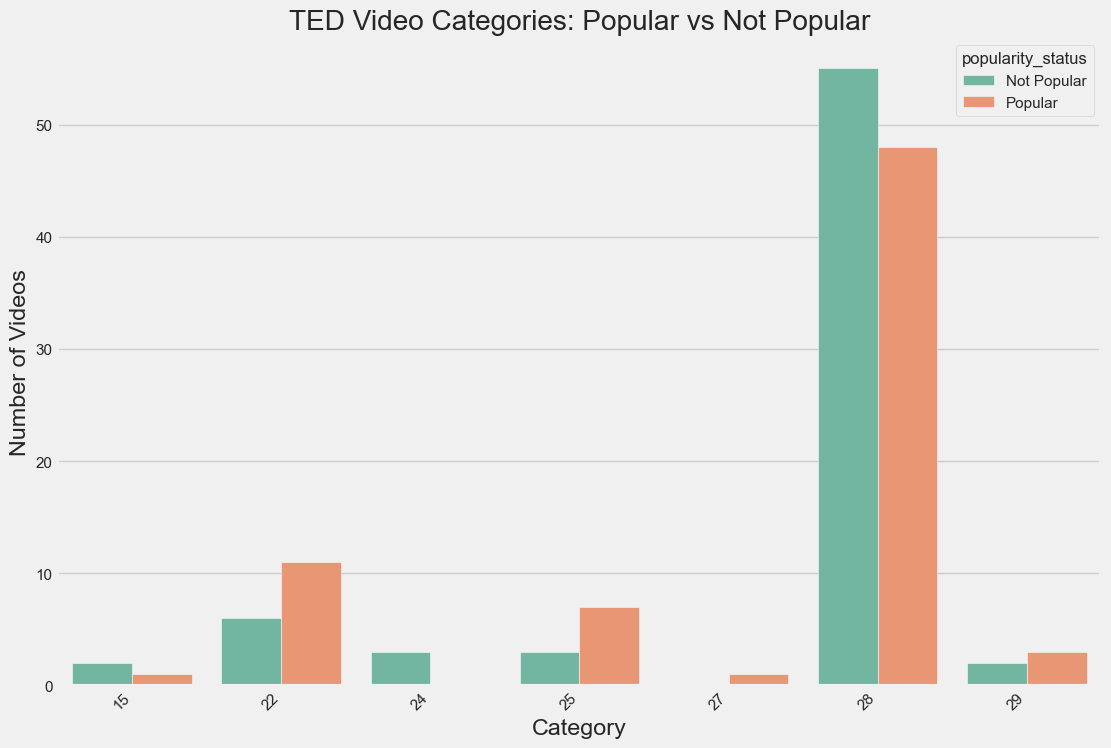

In [128]:
# Step 10: Analysis of Categories and Popularity
plt.figure(figsize=(12, 8))
sns.countplot(x='category', hue='popularity_status', data=df, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('TED Video Categories: Popular vs Not Popular')
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.show()

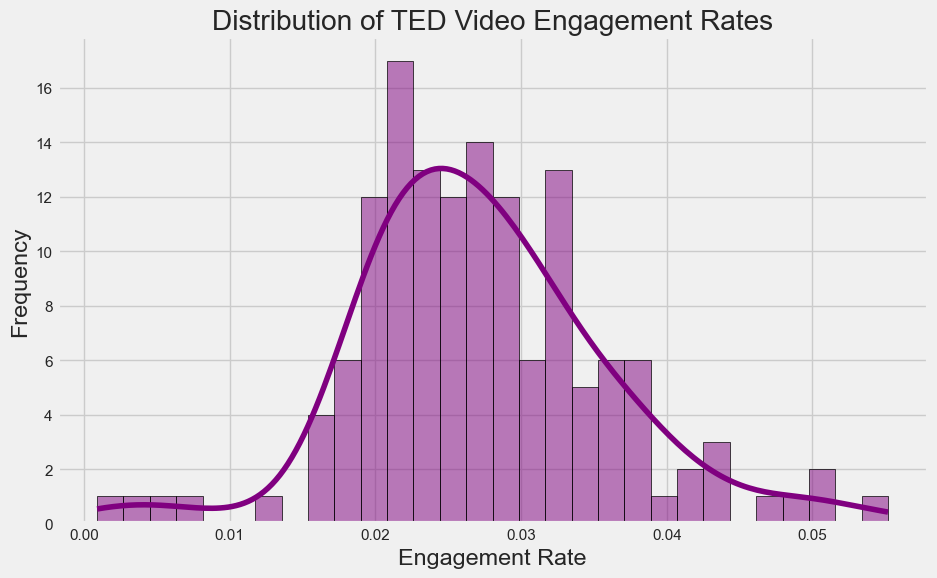

In [129]:
# Step 11: Advanced Analysis - Engagement Rate
df['engagement_rate'] = (df['like_count'] + df['comment_count']) / df['view_count']

# Visualize the distribution of engagement rates
plt.figure(figsize=(10, 6))
sns.histplot(df['engagement_rate'], bins=30, kde=True, color='purple', edgecolor='black')
plt.title('Distribution of TED Video Engagement Rates')
plt.xlabel('Engagement Rate')
plt.ylabel('Frequency')
plt.show()

In [130]:
# Step 12: Insights and Recommendations
print("\nInsights and Recommendations:")
important_features = corr_matrix['view_count'].sort_values(ascending=False)
print("\nTop Features Related to Video Popularity:")
print(important_features)


Insights and Recommendations:

Top Features Related to Video Popularity:
view_count          1.000000
like_count          0.938723
comment_count       0.905838
duration_seconds    0.049973
category           -0.103556
published_at       -0.197985
duration                 NaN
title                    NaN
description              NaN
tags                     NaN
Name: view_count, dtype: float64


## Recommendations

1. **Increase Engagement:** Encourage viewers to engage with videos through likes and comments as they are highly correlated with popularity.

2. **Optimal Duration:** Most popular videos tend to have a moderate duration. Experimenting with different lengths might help in optimizing viewer retention.

3. **Content Categorization:** Some categories show a higher proportion of popular videos. Focus on creating content in these high-performing categories.

4. **Engagement Rate:** Videos with high engagement rates (likes/comments per view) are more likely to be popular. Consider strategies like Q&A, polls, or discussions to boost engagement.

5. **Benchmark Popularity:** Videos that surpass the median view count tend to be 'Popular.' Analyzing videos that fall below this threshold can highlight areas for improvement in content strategy.
